In [1]:
#1Data preprocessing
import os
import validators
from rdflib import URIRef

data_path = './x/'

for file in os.listdir(data_path):
    if not file.endswith('.nq'):
        continue
    with open(data_path+file,'r',errors='ignore') as f:
        text = f.readlines()

    new_text = []
    for line in text:
        line_original = []
        line_parsed = []
        tmp = line.split('>')
        for i in range(len(tmp)):
            tmp2 = tmp[i].split('<')[-1]
            if i == 2 and '"' in tmp2:
                line_original.append(' '.join(tmp2.strip().split()[:-1]))
                line_original.append(' .\n')
            else:
                line_original.append(tmp2)

        for i in range(len(line_original)-1):
            if not validators.url(line_original[i]):
                print("{} --- {}".format(file,line_original[i]))
                line_parsed.append(line_original[i])
            else:
                line_parsed.append('<'+''.join(line_original[i].split())+'>')
        new_line_str = ' '.join(line_parsed[:3])+' .'
        new_text.append(new_line_str)
        
    if new_text and new_text[-1].strip() == '.':
            new_text.pop()  
    new_text_str = '\n'.join(new_text)

    with open(data_path+file,'w') as f:
        f.write(new_text_str)


In [2]:
#2 Parse the RDF graph data
from rdflib import Graph, RDF, RDFS, URIRef, Namespace
import os
from copy import deepcopy
from SPARQLQuery import SPARQLQuery
from scipy.stats import entropy
from scipy.special import softmax
import numpy as np
from sklearn.preprocessing import normalize

class Parser:
    """
    This class calculates the probability of each frame occurrence-predicate pair to have a particular type as range role
    input: directory_path: directory from where to load the files containing the different graphs
    """
#1Class initialization
    def __init__(self,directory_path):
        self.rdf = Namespace("http://www.w3.org/1999/02/22-rdf-syntax-ns#")
        self.rdfs = Namespace("http://www.w3.org/2000/01/rdf-schema#")
        self.fred = Namespace("http://www.ontologydesignpatterns.org/ont/fred/domain.owl#")
        self.dul = Namespace("http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#")
        self.owl = Namespace("http://www.w3.org/2002/07/owl#")
        self.pb_role = Namespace("https://w3id.org/framester/pb/localrole/")
        self.pb_frame = Namespace("https://w3id.org/framester/pb/data/")
        self.fst_schema = Namespace("https://w3id.org/framester/schema/")
        self.vn_role = Namespace("http://www.ontologydesignpatterns.org/ont/vn/abox/role/")
        self.fn_frame = Namespace("https://w3id.org/framester/framenet/abox/frame/")
        self.quantifiers = Namespace("http://www.ontologydesignpatterns.org/ont/fred/quantifiers.owl#")
        self.wd = Namespace("https://www.wikidata.org/wiki/")
        self.db = Namespace("http://dbpedia.org/resource/")
        self.verbatlas = Namespace("http://verbatlas.org/")
        self.schema = Namespace("http://schema.org/")
        self.wn = Namespace("https://w3id.org/framester/wn/wn30/schema/")

        self.namespace2uri = {
            'rdf': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#',
            'rdfs': 'http://www.w3.org/2000/01/rdf-schema#',
            'dul': 'http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#',
            'fred': 'http://www.ontologydesignpatterns.org/ont/fred/domain.owl#',
            'owl': 'http://www.w3.org/2002/07/owl#',
            'pb_role': 'https://w3id.org/framester/pb/localrole/',
            'pb_frame': 'https://w3id.org/framester/pb/data/',
            'fst_schema': 'https://w3id.org/framester/schema/',
            'vn_role': 'http://www.ontologydesignpatterns.org/ont/vn/abox/role/',
            'fn_frame': 'https://w3id.org/framester/framenet/abox/frame/',
            'quantifiers': 'http://www.ontologydesignpatterns.org/ont/fred/quantifiers.owl#',
            'wd': 'https://www.wikidata.org/wiki/',
            'db': 'http://dbpedia.org/resource/',
            'wn': 'https://w3id.org/framester/wn/wn30/schema/',
            'verbatlas': 'http://verbatlas.org/',
            'schema': 'http://schema.org/',
        }

        self.uri2namespace = {v:k for k,v in self.namespace2uri.items()}

        self.directory_path = directory_path

        self.sparql_query = SPARQLQuery()

        self.count_sparql_errors = 0

        self.metrics = ['subj_pred_obj_frequency','subj_pred_obj_probability','subj_pred_obj_total_probability',
            'subj_pred_frequency','subj_pred_probability','subj_pred_total_probability',
            'subj_frequency','subj_probability','subj_total_probability', 'frequency'
        ]
#2.Create and return a RDFLib graph (Graph) object.
#Bind different namespaces to the graph through the graph.bind method.
    def graph_init(self,file_path):
        graph = Graph()
        graph.parse(file_path)

        graph.bind('rdf',URIRef(self.rdf),False)
        graph.bind('rdfs',URIRef(self.rdfs),False)
        graph.bind('dul',URIRef(self.dul),False)
        graph.bind('fred',URIRef(self.fred),False)
        graph.bind('owl',URIRef(self.owl),False)
        graph.bind('pb_role',URIRef(self.pb_role),False)
        graph.bind('pb_frame',URIRef(self.pb_frame),False)
        graph.bind('fst_schema',URIRef(self.fst_schema),False)
        graph.bind('vn_role',URIRef(self.vn_role),False)
        graph.bind('fn_frame',URIRef(self.fn_frame),False)
        graph.bind('quantifiers',URIRef(self.quantifiers),False)
        graph.bind('wd',URIRef(self.wd),False)
        graph.bind('db',URIRef(self.db),False)
        graph.bind('wn',URIRef(self.wn),False)
        graph.bind('verbatlas',URIRef(self.verbatlas),False)
        graph.bind('schema',URIRef(self.schema),False)
        return graph

    """
    get_frame_occ_list: recursive function which finds the instances of frame occurrences.
    Input: object(optional) -> the input is a class, treated as an object when looking for triples. The parameter is ONLY used for the recursion
                   hence this function MUST be called without the parameter for its intended use.
    Output: list of frame occurrences
    """
    
    # Recursive function to find frame instances in the graph.
    def get_frame_occ_list(self, graph, object=None):
        result_list = []  # Create an empty list to store found frame instances

        if object is None:
            # If no object parameter is provided, enter this branch
            # Find all classes that are direct or indirect subclasses of 'dul.Event'
            # and recursively call to find their instances
            for s, p, o in graph.triples((None, RDFS.subClassOf, self.dul.Event)):
                result_list.extend(self.get_frame_occ_list(graph, s))
        else:
            # If an object parameter is provided, enter this branch
            # Find all classes that are direct or indirect subclasses of 'object'
            # and recursively call to find their instances
            for s, p, o in graph.triples((None, RDFS.subClassOf, object)):
                result_list.extend(self.get_frame_occ_list(graph, s))

            # Find all resources that are directly or indirectly marked as 'object' type
            # and add them to the result list
            for s, p, o in graph.triples((None, RDF.type, object)):
                result_list.append(s)

        return result_list  # Return a list containing all found instances

    # Convert a URI reference (URIRed) to a name and return the name.
    def uriref2name(self, uriref):
        splitted = str(uriref).split('/')[-1].split('#')  # Split the URI and find its corresponding namespace
        uri_base, name = '/'.join(splitted[:-1]), splitted[-1]

        if uri_base in self.uri2namespace.keys():
            return self.uri2namespace[uri_base] + ':' + name
        else:
            return name


#5 Count the frequency of occurrences of different framework instances, predicates and objects
    def get_frequencies_dict(self):
        frequencies = {}
        frequencies['frequency'] = 0
        for file_path in os.listdir(self.directory_path):
            if file_path.split('.')[-1] != 'nq': continue
            print("Processing file:", file_path)
            graph = self.graph_init(os.path.join(self.directory_path,file_path))
            frame_occurrence_list = self.get_frame_occ_list(graph)
            for frame_occurrence in frame_occurrence_list:
                frame_occurrence_type = graph.value(frame_occurrence,self.rdf.type,None)
                frame_occurrence_str = self.uriref2name(frame_occurrence_type)
                print("Frame Occurrence Type:", frame_occurrence_str)
                if str(frame_occurrence_type) not in frequencies.keys():
                    frequencies[str(frame_occurrence_type)] = {}
                    frequencies[str(frame_occurrence_type)]['subj_frequency'] = 0
                for _,p,_ in graph.triples((frame_occurrence,None,None)):
                    if p.startswith(self.pb_role):
                        p_str = self.uriref2name(p)
                        types = []
                        if str(p) not in frequencies[str(frame_occurrence_type)].keys():
                            frequencies[str(frame_occurrence_type)][str(p)] = {}
                            frequencies[str(frame_occurrence_type)][str(p)]['subj_pred_frequency'] = 0
                        for _,_,o in graph.triples((frame_occurrence,p,None)):
                            o_type = str(graph.value(o,self.rdf.type,None))
                            o_type_str = self.uriref2name(o_type)
                            if o_type not in frequencies[str(frame_occurrence_type)][str(p)].keys():
                                frequencies[str(frame_occurrence_type)][str(p)][o_type] = {}
                                frequencies[str(frame_occurrence_type)][str(p)][o_type]['subj_pred_obj_frequency'] = 0
                            frequencies[str(frame_occurrence_type)][str(p)][o_type]['subj_pred_obj_frequency']+=1
                            frequencies[str(frame_occurrence_type)][str(p)]['subj_pred_frequency']+=1
                            frequencies[str(frame_occurrence_type)]['subj_frequency']+=1
                            frequencies['frequency']+=1
                            types.append(o_type)
                        common_ancestor_type, cardinality = self.generalize_common(graph,types)
                        if common_ancestor_type not in frequencies[str(frame_occurrence_type)][str(p)].keys(): #TODO: add generalization info
                            frequencies[str(frame_occurrence_type)][str(p)][str(common_ancestor_type)] = {}
                            frequencies[str(frame_occurrence_type)][str(p)][str(common_ancestor_type)]['subj_pred_obj_frequency'] = cardinality
                        #frequencies = self.generalize(frequencies,graph,frame_occurrence_str,p_str,o_type)
        return frequencies
    
#6Calculate support and confidence
    def calculate_metrics(self,frequency,total_frequency,frequency_previous):
        support = float(frequency)/float(total_frequency)
        confidence = float(frequency)/float(frequency_previous)
        return support, confidence

#7 Calculate support and confidence for different elements in the frequency dictionary.
    def get_metrics_dict(self,frequency_dict):
        for k1,v1 in frequency_dict.items():
            if k1 in self.metrics: continue
            for k2,v2 in v1.items():
                if k2 in self.metrics: continue
                for k3,v3 in v2.items():
                    if k3 in self.metrics: continue
                    frequency_dict[k1][k2][k3]['subj_pred_obj_total_probability'], frequency_dict[k1][k2][k3]['subj_pred_obj_probability']= \
                        self.calculate_metrics(frequency_dict[k1][k2][k3]['subj_pred_obj_frequency'], frequency_dict['frequency'], frequency_dict[k1][k2]['subj_pred_frequency'])
                frequency_dict[k1][k2]['subj_pred_total_probability'], frequency_dict[k1][k2]['subj_pred_probability']= \
                    self.calculate_metrics(frequency_dict[k1][k2]['subj_pred_frequency'], frequency_dict['frequency'], frequency_dict[k1]['subj_frequency'])
            frequency_dict[k1]['subj_total_probability'], frequency_dict[k1]['subj_probability']= \
                self.calculate_metrics(frequency_dict[k1]['subj_frequency'], frequency_dict['frequency'], frequency_dict['frequency'])

        return frequency_dict

#8 Generalize different types (objects) to types with a common ancestor by recursively accessing the WordNet hierarchy.
    def generalize_common(self,graph,types,k=1): 
        wn_types = []
        for o in types: #extract wn alignments for each type
            o_wn = graph.value(URIRef(o),self.owl.equivalentClass,None)
            if o_wn == None: continue
            wn_types.append(o_wn)
        generalizations = []
        for type1 in wn_types: #extract wn hierarchy path for each type
            generalized_type = [type1]
            for i in range(k):
                query_text = 'SELECT ?o WHERE {{ <'+str(type1)+'> <'+str(self.wn.hyponymOf)+'> ?o .}}'
                try:
                    result = self.sparql_query.query(query_text)
                except:
                    break
                if isinstance(result,bytes) or result == None or len(result['results']['bindings']) == 0:
                    break
                wn_generalized_type = result['results']['bindings'][0]['o']['value']
                generalized_type.append(wn_generalized_type)
                type1 = wn_generalized_type
            generalizations.append(generalized_type)

        common_ancestor_type = None
        if len(generalizations) == 0:
            return common_ancestor_type, 0

        for type in generalizations[0]:
            common_ancestor = True
            for i in range(1,len(generalizations)):
                if type not in generalizations[i]:
                    common_ancestor = False
                    break
            if common_ancestor:
                common_ancestor_type = type
                break

        return common_ancestor_type, len(generalizations)


#9 By accessing the WordNet hierarchy, generalize different types into multiple generalized types and update the frequency dictionary.
    def generalize(self,frequency_dict,graph,s,p,o): #naive generalization function, visiting WordNet taxonomy by visiting 3 steps of the hierarchy.
                             #Each generalization found (even non common ones) are added inside the final result
                             #It is quicker than generalize_common due to the reduced amount of SPARQL queries
        def update_graph(self,frequency_dict,s,p,o,o_wn_generalized_str):
            if o_wn_generalized_str not in frequency_dict[s][p].keys():
                frequency_dict[s][p][o_wn_generalized_str] = {}
                frequency_dict[s][p][o_wn_generalized_str]['subj_pred_obj_frequency'] = 0
                frequency_dict[s][p][o_wn_generalized_str]['generalizes'] = []
            frequency_dict[s][p][o_wn_generalized_str]['subj_pred_obj_frequency'] += 1
            o_str = self.uriref2name(o)
            if o_str not in frequency_dict[s][p][o_wn_generalized_str]['generalizes']:
                frequency_dict[s][p][o_wn_generalized_str]['generalizes'].append(o_str)
            return frequency_dict

        o_wn = graph.value(o,self.owl.equivalentClass,None)
        if o_wn == None:
            return frequency_dict

        query_text = 'SELECT ?o ?o2 ?o3 WHERE {{ <'+str(o_wn)+'> <'+str(self.wn.hyponymOf)+'> ?o . ?o <'+str(self.wn.hyponymOf)+'> ?o2 . ?o2 <'+str(self.wn.hyponymOf)+'> ?o3}} LIMIT 10'
        try:
            result = self.sparql_query.query(query_text)
        except:
            self.count_sparql_errors += 1
            return frequency_dict

        if isinstance(result,bytes) or result == None or len(result['results']['bindings']) == 0:
            return frequency_dict

        o_wn_generalized = result['results']['bindings'][0]['o']['value']
        o_wn_generalized_str = str(o_wn_generalized)

        o_wn_generalized2 = result['results']['bindings'][0]['o2']['value']
        o_wn_generalized2_str = str(o_wn_generalized2)

        o_wn_generalized3 = result['results']['bindings'][0]['o3']['value']
        o_wn_generalized3_str = str(o_wn_generalized3)

        frequency_dict = update_graph(self,frequency_dict,s,p,o,o_wn_generalized_str)
        frequency_dict = update_graph(self,frequency_dict,s,p,o,o_wn_generalized2_str)
        frequency_dict = update_graph(self,frequency_dict,s,p,o,o_wn_generalized3_str)

        return frequency_dict
    
#10 Clear frequency dictionary entries that do not meet the criteria, especially those that are not generalized.
    def clean_dictionary(self,frequency_dict):
        copied_dict = deepcopy(frequency_dict)
        for k1,v1 in frequency_dict.items():
            if not isinstance(v1,dict): continue
            for k2,v2 in v1.items():
                if not isinstance(v2,dict): continue
                for k3,v3 in v2.items():
                    if not isinstance(v3,dict): continue
                    if 'generalizes' in v3.keys() and len(v3['generalizes']) == 1:
                        del copied_dict[k1][k2][k3]

        return copied_dict
    
#11 Print statistics about the most common types and combinations
    def print_statistics(self,frequency_dict): #used for calculating statistics about most frequent groupings or most frequent types
        most_frequent_types = {}
        for k1,v1 in frequency_dict.items():
            if not isinstance(v1,dict): continue
            for k2,v2 in v1.items():
                if not isinstance(v2,dict): continue
                for k3,v3 in v2.items():
                    if not isinstance(v3,dict): continue
                    if k3 not in most_frequent_types.keys():
                        most_frequent_types[k3] = 0
                    print("{} --- {}".format(k3,type(k3)))
                    most_frequent_types[k3] += 1
        most_frequent_groupings = {}
        most_frequent_groupings_count = {}
        for k1,v1 in frequency_dict.items():
            if not isinstance(v1,dict): continue
            for k2,v2 in v1.items():
                if not isinstance(v2,dict): continue
                for k3,v3 in v2.items():
                    if not isinstance(v3,dict): continue
                    if 'generalizes' in v3.keys():
                        if k3 not in most_frequent_groupings.keys():
                            most_frequent_groupings[k3] = set()
                            most_frequent_groupings_count[k3] = 0
                        for el in v3['generalizes']:
                            most_frequent_groupings[k3].add(el)

                        most_frequent_groupings_count[k3] += 1

        sorted_keys = sorted(most_frequent_types, key=most_frequent_types.get, reverse=True)
        for r in sorted_keys:
                print("{} --- {}".format(r, most_frequent_types[r]))

        print("-----------------------")

        sorted_keys = sorted(most_frequent_groupings_count, key=most_frequent_groupings_count.get, reverse=True)
        for r in sorted_keys:
            print("{} --- {} --- {}".format(r, most_frequent_groupings_count[r], most_frequent_groupings[r]))

#12 Get the frequency of occurrence information of various types in the frequency dictionary.
    def get_types(self,frequency_dict,zero=False):
        types = {}
        for k1,v1 in frequency_dict.items():
            if not isinstance(v1,dict): continue
            for k2,v2 in v1.items():
                if not isinstance(v2,dict): continue
                for k3,v3 in v2.items():
                    if not isinstance(v3,dict): continue
                    if zero:
                        types[k3] = 0.0001
                    elif k3 not in types.keys():
                        types[k3] = v3['subj_pred_obj_frequency']
                    else:
                        types[k3] += v3['subj_pred_obj_frequency']
        return types
    
#13 Compute the type preference of a specific framework instance, as measured by calculating the entropy of the type distribution.
    def get_preference(self,frequency_dict,frame):
        types = self.get_types(frequency_dict)
        types_given_frame = self.get_types(frequency_dict,zero=True)
        for k,v1 in frequency_dict[frame].items():
            if not isinstance(v1,dict): continue
            for k2,v2 in v1.items():
                if not isinstance(v2,dict): continue
                types_given_frame[k2] += v2['subj_pred_obj_frequency']
        types_list = normalize(np.array([v for k,v in types.items()])[:,np.newaxis], axis=0).reshape(-1)
        types_names = [k for k,v in types.items()]
        types_given_frame_list = normalize(np.array([v for k,v in types_given_frame.items()])[:,np.newaxis], axis=0).reshape(-1)
        return frame, entropy(types_given_frame_list,types_list)


In [3]:
#1.1 Load and read data file
from rdflib import Dataset

def read_nq_file(file_path, limit=30):
    dataset = Dataset()
    dataset.parse(file_path, format='nquads')
    for i, quad in enumerate(dataset.quads((None, None, None, None))):
        if i >= limit:
            break
        subj, pred, obj, graph = quad
        print(f"Subject: {subj}, Predicate: {pred}, Object: {obj}")


nq_file_path = "x/0_1_EN.nq"
read_nq_file(nq_file_path)


Subject: https://w3id.org/framester/pb/data/merge-01, Predicate: http://www.w3.org/2000/01/rdf-schema#label, Object: https://w3id.org/polifonia/resource/Graph/MusicBO_5_410_amr
Subject: https://w3id.org/polifonia/resource/MusicBO_5_410_amr/Theme, Predicate: http://www.w3.org/2000/01/rdf-schema#subClassOf, Object: https://w3id.org/framester/wn/wn30/instances/supersense-noun_communication
Subject: https://w3id.org/polifonia/resource/MusicBO_5_410_amr/compose_1, Predicate: https://w3id.org/framester/schema/subsumedUnder, Object: http://verbatlas.org/0382f
Subject: https://w3id.org/framester/pb/data/general-02, Predicate: http://www.w3.org/2000/01/rdf-schema#subClassOf, Object: http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#Event
Subject: https://w3id.org/polifonia/resource/MusicBO_5_410_amr/merge_1, Predicate: https://w3id.org/framester/schema/subsumedUnder, Object: https://w3id.org/framester/framenet/abox/frame/Cause_to_amalgamate
Subject: https://w3id.org/framester/pb/data/compos

In [4]:
#1.2 Get a list of frame instances
directory_path = "x"
parser = Parser(directory_path)
for file_path in os.listdir(directory_path):
    if file_path.endswith('.nq'):
        graph = parser.graph_init(os.path.join(directory_path, file_path))
        frame_occurrences = parser.get_frame_occ_list(graph)
        print("Frame Occurrences in {}: {}".format(file_path, frame_occurrences))
        
#frame_occurrences  represent different concepts or entities in the music BO knowledge graph, such as music events, musicians, musical works, etc.
#frame_occurrences can be used to compare identical or similar musical concepts in different graphs

Frame Occurrences in 0_1_ITA.nq: [rdflib.term.URIRef('https://w3id.org/polifonia/resource/MusicBO_105_6991_amr-ml/express_1'), rdflib.term.URIRef('https://w3id.org/polifonia/resource/MusicBO_105_6991_amr-ml/treat_1'), rdflib.term.URIRef('https://w3id.org/polifonia/resource/MusicBO_105_6991_amr-ml/have-org-role_1')]
Frame Occurrences in 0_6_EN.nq: [rdflib.term.URIRef('https://w3id.org/polifonia/resource/MusicBO_6_957_amr/act_1'), rdflib.term.URIRef('https://w3id.org/polifonia/resource/MusicBO_6_957_amr/habitual_1'), rdflib.term.URIRef('https://w3id.org/polifonia/resource/MusicBO_6_957_amr/foresee_1'), rdflib.term.URIRef('https://w3id.org/polifonia/resource/MusicBO_6_957_amr/forbid_1'), rdflib.term.URIRef('https://w3id.org/polifonia/resource/MusicBO_6_957_amr/close_1'), rdflib.term.URIRef('https://w3id.org/polifonia/resource/MusicBO_6_957_amr/agree_1'), rdflib.term.URIRef('https://w3id.org/polifonia/resource/MusicBO_6_957_amr/observe_1')]
Frame Occurrences in 0_4_EN.nq: [rdflib.term.URIR

In [5]:
#1.4 Analyze relationships between frame instances
from rdflib import ConjunctiveGraph

g = ConjunctiveGraph()

with open("x/0_1_EN.nq", "rb") as nq_file:
    nq_data = nq_file.read()
    g.parse(data=nq_data, format="nquads")

#the relationship between two frames
frame_occurrences1 = URIRef("https://w3id.org/polifonia/resource/MusicBO_5_410_amr/manage_1")
frame_occurrences2 = URIRef("https://w3id.org/polifonia/resource/MusicBO_5_410_amr/merge_1")

relationships = list(g.predicate_objects(frame_occurrences1))
for predicate, obj in relationships:
    if obj == frame_occurrences2:
        print(f"The relationship between {frame_occurrences1} and {frame_occurrences2} is {predicate}")
        
print('-'*100)
# Relationships between frames and other entities
frame_occurrences3 = URIRef("https://w3id.org/polifonia/resource/MusicBO_5_410_amr/general_1")
relationships = list(g.predicate_objects(frame_occurrences3))
for predicate, obj in relationships:
    print(f"The relationship between {frame_occurrences3} and {obj} is {predicate}")

    
'''

1. The "https://w3id.org/framester/pb/localrole/deed_accomplished" relationship connects the frame instances "https://w3id.org/polifonia/resource/MusicBO_5_410_amr/manage_1" and "https://w3id.org /polifonia/resource/MusicBO_5_410_amr/merge_1". The name of this relationship indicates that there may be some kind of "behavior completion" relationship between the two frame instances, which may mean that one frame instance manages or controls another frame instance and completes a certain task.

2. The "https://w3id.org/framester/pb/localrole/common_thing" relationship connects the frame instances "https://w3id.org/polifonia/resource/MusicBO_5_410_amr/general_1" and "https://w3id.org /polifonia/resource/MusicBO_5_410_amr/character_2". The name of this relationship indicates that there may be something "in common" or "common characteristics" between the two frame instances. It might mean that the two frame instances share some common property or characteristic.

3. The "https://w3id.org/framester/pb/localrole/entities_sharing_arg_1" relationship connects the frame instances "https://w3id.org/polifonia/resource/MusicBO_5_410_amr/general_1" and "https://w3id.org /polifonia/resource/MusicBO_5_410_amr/piece_1". The name of this relationship indicates that some parameters or entities may be shared between the two frame instances. This may indicate that there is some kind of parameter passing or sharing of an entity between the two frame instances.

4. The "http://www.w3.org/1999/02/22-rdf-syntax-ns#type" relationship connects the frame instances "https://w3id.org/polifonia/resource/MusicBO_5_410_amr/general_1" and "https://w3id.org/framester/pb/data/general-02". This relationship means that the frame instance "https://w3id.org/polifonia/resource/MusicBO_5_410_amr/general_1" is an instance of type "https://w3id.org/framester/pb/data/general-02". This may indicate that "https://w3id.org/polifonia/resource/MusicBO_5_410_amr/general_1" belongs to a specific category or type, and the frame instance can be classified or tagged based on this information.
'''

The relationship between https://w3id.org/polifonia/resource/MusicBO_5_410_amr/manage_1 and https://w3id.org/polifonia/resource/MusicBO_5_410_amr/merge_1 is https://w3id.org/framester/pb/localrole/deed_accomplished
----------------------------------------------------------------------------------------------------
The relationship between https://w3id.org/polifonia/resource/MusicBO_5_410_amr/general_1 and https://w3id.org/polifonia/resource/MusicBO_5_410_amr/character_2 is https://w3id.org/framester/pb/localrole/common_thing
The relationship between https://w3id.org/polifonia/resource/MusicBO_5_410_amr/general_1 and https://w3id.org/polifonia/resource/MusicBO_5_410_amr/piece_1 is https://w3id.org/framester/pb/localrole/entities_sharing_arg_1
The relationship between https://w3id.org/polifonia/resource/MusicBO_5_410_amr/general_1 and https://w3id.org/framester/pb/data/general-02 is http://www.w3.org/1999/02/22-rdf-syntax-ns#type


'\n\n1. The "https://w3id.org/framester/pb/localrole/deed_accomplished" relationship connects the frame instances "https://w3id.org/polifonia/resource/MusicBO_5_410_amr/manage_1" and "https://w3id.org /polifonia/resource/MusicBO_5_410_amr/merge_1". The name of this relationship indicates that there may be some kind of "behavior completion" relationship between the two frame instances, which may mean that one frame instance manages or controls another frame instance and completes a certain task.\n\n2. The "https://w3id.org/framester/pb/localrole/common_thing" relationship connects the frame instances "https://w3id.org/polifonia/resource/MusicBO_5_410_amr/general_1" and "https://w3id.org /polifonia/resource/MusicBO_5_410_amr/character_2". The name of this relationship indicates that there may be something "in common" or "common characteristics" between the two frame instances. It might mean that the two frame instances share some common property or characteristic.\n\n3. The "https://w3id

In [6]:
#1.3 Extract the attributes and relationships of the same entities in all RDF graphs, 
# and compare their attribute values and associated relationships

from rdflib import Graph
import os

# Define a function to extract properties and relations of entities
def extract_entity_properties_relations(graph):
    entity_data = {}
    for subj in graph.subjects():
        properties = {}
        relations = set()
        for prop, value in graph.predicate_objects(subj):
            properties[prop] = value
        for obj in graph.objects(subj):
            relations.add(obj)
        entity_data[subj] = {"properties": properties, "relations": relations}
    return entity_data

# Define a dictionary to store entity data from different graphs
entity_data_by_graph = {}

# Specify the directory path containing RDF files
directory_path = "x"

# Iterate through each RDF file in the directory
for file_path in os.listdir(directory_path):
    if file_path.endswith('.nq'):
        graph = Graph()
        graph.parse(os.path.join(directory_path, file_path), format="nquads")
        entity_data_by_graph[file_path] = extract_entity_properties_relations(graph)

# Compare properties and relations of the same entities in different graphs
graph_files = list(entity_data_by_graph.keys())
for i in range(len(graph_files)):
    for j in range(i+1, len(graph_files)):
        graph1_file = graph_files[i]
        graph2_file = graph_files[j]
        
        entity_data1 = entity_data_by_graph[graph1_file]
        entity_data2 = entity_data_by_graph[graph2_file]
        
        common_entities = set(entity_data1.keys()) & set(entity_data2.keys())
        
        print(f"Common Entities between {graph1_file} and {graph2_file}:")
        for entity_uri in common_entities:
            print(f"Entity URI: {entity_uri}")
            
            properties1 = entity_data1[entity_uri]["properties"]
            properties2 = entity_data2[entity_uri]["properties"]
            
            # Compare property values
            for prop in properties1:
                if prop in properties2:
                    if properties1[prop] == properties2[prop]:
                        print(f"  Same {prop}: {properties1[prop]}")
                    else:
                        print(f"  Different {prop}:")
                        print(f"    {properties1[prop]} (in {graph1_file})")
                        print(f"    {properties2[prop]} (in {graph2_file})")
            
            relations1 = entity_data1[entity_uri]["relations"]
            relations2 = entity_data2[entity_uri]["relations"]
            
            # Compare associated relations
            common_relations = relations1 & relations2
            if common_relations:
                print(f"  Common Relations: {common_relations}")
            else:
                print("  No common relations found.")
            
            print("\n")


Common Entities between 0_1_ITA.nq and 0_6_EN.nq:
Common Entities between 0_1_ITA.nq and 0_4_EN.nq:
Common Entities between 0_1_ITA.nq and 0_2_EN.nq:
Common Entities between 0_1_ITA.nq and 0_3_ITA.nq:
Entity URI: https://w3id.org/framester/pb/data/have-org-role-91
  Same http://www.w3.org/2000/01/rdf-schema#subClassOf: http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#Event
  Common Relations: {rdflib.term.URIRef('http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#Event')}


Common Entities between 0_1_ITA.nq and 0_5_EN.nq:
Common Entities between 0_1_ITA.nq and 0_7_ITA.nq:
Common Entities between 0_1_ITA.nq and 0_7_EN.nq:
Common Entities between 0_1_ITA.nq and 0_3_EN.nq:
Common Entities between 0_1_ITA.nq and 0_9_ITA.nq:
Common Entities between 0_1_ITA.nq and 0_5_ITA.nq:
Common Entities between 0_1_ITA.nq and 0_1_EN.nq:
Common Entities between 0_1_ITA.nq and 0_2_ITA.nq:
Common Entities between 0_1_ITA.nq and 0_9_EN.nq:
Common Entities between 0_1_ITA.nq and 0_6_ITA.nq:
Common E

In [7]:
#1.5 Find the most frequently frame_occurrences
import os
from collections import Counter
from rdflib import Graph, URIRef

directory_path = "x"

frame_occurrences_statistics = Counter()

for file_path in os.listdir(directory_path):
    if file_path.endswith('.nq'):
        graph = Graph()

        graph.load(os.path.join(directory_path, file_path), format="nquads")

        for subject, predicate, obj in graph.triples((None, None, None)):
            if isinstance(subject, URIRef):
                frame_occurrences_statistics[subject] += 1

for frame_occurrences, count in frame_occurrences_statistics.items():
    print(f"frame_occurrences: {frame_occurrences}, {count}")

most_common_frame_occurrences = frame_occurrences_statistics.most_common(1)
if most_common_frame_occurrences:
    print(f"Most common frame_occurrences: {most_common_frame_occurrences[0][0]}, The number of occurrences:  {most_common_frame_occurrences[0][1]}")
else:
    print("No frame_occurrences appears")



frame_occurrences: https://w3id.org/polifonia/resource/MusicBO_105_6991_amr-ml/Talvolta, 3
frame_occurrences: https://w3id.org/polifonia/resource/MusicBO_105_6991_amr-ml/Orrore, 3
frame_occurrences: https://w3id.org/polifonia/resource/MusicBO_105_6991_amr-ml/Drammatica, 4
frame_occurrences: https://w3id.org/polifonia/resource/MusicBO_105_6991_amr-ml/express_1, 6
frame_occurrences: https://w3id.org/polifonia/resource/MusicBO_105_6991_amr-ml/have-org-role_1, 3
frame_occurrences: https://w3id.org/polifonia/resource/MusicBO_105_6991_amr-ml/toccano_1, 4
frame_occurrences: https://w3id.org/polifonia/resource/MusicBO_105_6991_amr-ml/treat_1, 7
frame_occurrences: https://w3id.org/framester/pb/data/treat-01, 2
frame_occurrences: https://w3id.org/polifonia/resource/MusicBO_105_6991_amr-ml/Maestro, 3
frame_occurrences: https://w3id.org/polifonia/resource/MusicBO_105_6991_amr-ml/Toccano, 2
frame_occurrences: https://w3id.org/framester/wn/wn30/instances/synset-repugnance-noun-1, 1
frame_occurrences

In [8]:
#2.1 Get frequency dictionary and support/confidence information

from rdflib import Graph, RDF, RDFS, URIRef, Namespace
import os
from copy import deepcopy
from SPARQLQuery import SPARQLQuery
from scipy.stats import entropy
from scipy.special import softmax
import numpy as np
from sklearn.preprocessing import normalize
import pickle
import os

directory_path = "x"
parser = Parser(directory_path)

frequency_dict = parser.get_frequencies_dict()

file_name = 'frequency_dict.pkl'

folder_path = 'frequency_dict'

os.makedirs(folder_path, exist_ok=True)

file_path = os.path.join(folder_path, file_name)

with open(file_path, 'wb') as file:
    pickle.dump(frequency_dict, file)

metrics_dict = parser.get_metrics_dict(frequency_dict)

print('-'*100)

print('frequency_dict:',frequency_dict)

print('-'*1000)

print('metrics_dict:',metrics_dict)


Processing file: 0_1_ITA.nq
Frame Occurrence Type: express-01
Frame Occurrence Type: treat-01
Frame Occurrence Type: have-org-role-91
Processing file: 0_6_EN.nq
Frame Occurrence Type: act-02
Frame Occurrence Type: habitual-01
Frame Occurrence Type: foresee-01
Frame Occurrence Type: forbid-01
Frame Occurrence Type: close-01
Frame Occurrence Type: agree-01
Frame Occurrence Type: observe-01
Processing file: 0_4_EN.nq
Frame Occurrence Type: sing-01
Frame Occurrence Type: possible-01
Frame Occurrence Type: practice-01
Frame Occurrence Type: relieve-01
Frame Occurrence Type: embroider-01
Frame Occurrence Type: cite-01
Processing file: 0_2_EN.nq
Frame Occurrence Type: want-01
Frame Occurrence Type: seem-01
Processing file: 0_3_ITA.nq
Frame Occurrence Type: include-91
Frame Occurrence Type: quick-02
Frame Occurrence Type: have-org-role-91
Frame Occurrence Type: become-01
Frame Occurrence Type: procure-01
Frame Occurrence Type: progress-01
Processing file: 0_5_EN.nq
Frame Occurrence Type: excel

In [9]:
''''https://w3id.org/framester/pb/data/express-01': 这是一个框架实例，出现了1次。它有一个名为 'https://w3id.org/framester/pb/localrole/speaker' 的属性，该属性出现1次。属性有关于属性值（对象） 'https://w3id.org/polifonia/resource/MusicBO_105_6991_amr-ml/Person' 的信息，该属性值出现了1次。还提供了一些概率信息，如总概率和概率等。
'https://w3id.org/framester/pb/data/treat-01': 这是另一个框架实例，出现了2次。它有两个属性，分别是 'https://w3id.org/framester/pb/localrole/assumer_of_attribute' 和 'https://w3id.org/framester/pb/localrole/entity_treated'。这两个属性都有关于属性值（对象）和概率的信息。
'https://w3id.org/framester/pb/data/have-org-role-91': 这是第三个框架实例，出现了4次。它有两个属性，分别是 'https://w3id.org/framester/pb/localrole/office_holder' 和 'https://w3id.org/framester/pb/localrole/title_of_office_held'，每个属性都有关于属性值（对象）和概率的信息。'''

"'https://w3id.org/framester/pb/data/express-01': 这是一个框架实例，出现了1次。它有一个名为 'https://w3id.org/framester/pb/localrole/speaker' 的属性，该属性出现1次。属性有关于属性值（对象） 'https://w3id.org/polifonia/resource/MusicBO_105_6991_amr-ml/Person' 的信息，该属性值出现了1次。还提供了一些概率信息，如总概率和概率等。\n'https://w3id.org/framester/pb/data/treat-01': 这是另一个框架实例，出现了2次。它有两个属性，分别是 'https://w3id.org/framester/pb/localrole/assumer_of_attribute' 和 'https://w3id.org/framester/pb/localrole/entity_treated'。这两个属性都有关于属性值（对象）和概率的信息。\n'https://w3id.org/framester/pb/data/have-org-role-91': 这是第三个框架实例，出现了4次。它有两个属性，分别是 'https://w3id.org/framester/pb/localrole/office_holder' 和 'https://w3id.org/framester/pb/localrole/title_of_office_held'，每个属性都有关于属性值（对象）和概率的信息。"

In [10]:
#2.2 Find the frequency dictionary for a specific frame instance
frame_occurrences = 'https://w3id.org/framester/pb/data/treat-01'  

if frame_occurrences in frequency_dict:
    frame_info = frequency_dict[frame_occurrences]
    print(f"frame_occurrences: {frame_occurrences}")
    for key, value in frame_info.items():
        if isinstance(value, dict):
            print(f"  {key}:")
            for sub_key, sub_value in value.items():
                if isinstance(sub_value, dict):
                    print(f"    {sub_key}:")
                    for sub_sub_key, sub_sub_value in sub_value.items():
                        print(f"      {sub_sub_key}: {sub_sub_value}")
                else:
                    print(f"    {sub_key}: {sub_value}")
        else:
            print(f"  {key}: {value}")
else:
    print(f"frame_occurrences not found {frame_occurrences}")
    

frame_occurrences: https://w3id.org/framester/pb/data/treat-01
  subj_frequency: 2
  https://w3id.org/framester/pb/localrole/assumer_of_attribute:
    subj_pred_frequency: 1
    https://w3id.org/polifonia/resource/MusicBO_105_6991_amr-ml/Person:
      subj_pred_obj_frequency: 1
      subj_pred_obj_total_probability: 0.007692307692307693
      subj_pred_obj_probability: 1.0
    None:
      subj_pred_obj_frequency: 0
      subj_pred_obj_total_probability: 0.0
      subj_pred_obj_probability: 0.0
    subj_pred_total_probability: 0.007692307692307693
    subj_pred_probability: 0.5
  https://w3id.org/framester/pb/localrole/entity_treated:
    subj_pred_frequency: 1
    https://w3id.org/polifonia/resource/MusicBO_105_6991_amr-ml/Situation:
      subj_pred_obj_frequency: 1
      subj_pred_obj_total_probability: 0.007692307692307693
      subj_pred_obj_probability: 1.0
    None:
      subj_pred_obj_frequency: 0
      subj_pred_obj_total_probability: 0.0
      subj_pred_obj_probability: 0.0
   

In [11]:
#2.3 Find the frame instance with the highest subject frequency
max_frequency = 0
most_frequent_frame_occurrences = None

for frame_occurrences, info in frequency_dict.items():
    if isinstance(info, dict) and 'subj_frequency' in info:
        frequency = info['subj_frequency']
        if frequency > max_frequency:
            max_frequency = frequency
            most_frequent_frame_occurrences = frame_occurrences

if most_frequent_frame_occurrences is not None:
    print(f"The most frequent frame instance is：{most_frequent_frame_occurrences}")
    print(f"The corresponding frequency is：{max_frequency}")
else:
    print("No frame instance found")


The most frequent frame instance is：https://w3id.org/framester/pb/data/include-91
The corresponding frequency is：12


In [12]:
#3.1 Find all different types of URIs in one graph

graph = Graph()
graph.parse("x/0_1_EN.nq", format="nquads")

type_uris = set()

for subject, predicate, obj in graph.triples((None, RDF.type, None)):
    type_uris.add(obj)

for uri in type_uris:
    print(uri)


https://w3id.org/framester/pb/data/merge-01
https://w3id.org/polifonia/resource/MusicBO_5_410_amr/Person
https://w3id.org/polifonia/resource/MusicBO_5_410_amr/Character
https://w3id.org/framester/pb/data/general-02
https://w3id.org/polifonia/resource/MusicBO_5_410_amr/Piece
https://w3id.org/framester/pb/data/compose-02
https://w3id.org/polifonia/resource/MusicBO_5_410_amr/Neuter
http://www.w3.org/2002/07/owl#Thing
https://w3id.org/polifonia/resource/MusicBO_5_410_amr/Theme
https://w3id.org/polifonia/resource/MusicBO_5_410_amr/Technical
https://w3id.org/framester/pb/data/manage-02


In [13]:
#3.2 Statistics of the occurrence of different elements in RDF data
#Sort the most common types and combinations
parser.print_statistics(frequency_dict)


https://w3id.org/polifonia/resource/MusicBO_105_6991_amr-ml/Person --- <class 'str'>
None --- <class 'str'>
https://w3id.org/polifonia/resource/MusicBO_105_6991_amr-ml/Person --- <class 'str'>
None --- <class 'str'>
https://w3id.org/polifonia/resource/MusicBO_105_6991_amr-ml/Situation --- <class 'str'>
None --- <class 'str'>
https://w3id.org/polifonia/resource/MusicBO_105_6991_amr-ml/Person --- <class 'str'>
None --- <class 'str'>
https://w3id.org/polifonia/resource/MusicBO_105_5249_amr-ml/Person --- <class 'str'>
https://w3id.org/polifonia/resource/MusicBO_105_6991_amr-ml/Maestro --- <class 'str'>
https://w3id.org/framester/wn/wn30/instances/synset-maestro-noun-1 --- <class 'str'>
https://w3id.org/polifonia/resource/MusicBO_105_5249_amr-ml/Maestrini --- <class 'str'>
https://w3id.org/framester/wn/wn30/instances/synset-flutist-noun-1 --- <class 'str'>
https://w3id.org/polifonia/resource/MusicBO_6_957_amr/Authority --- <class 'str'>
https://w3id.org/framester/wn/wn30/instances/synset-au

In [14]:
#3.3 get the type preference of the framework instance
frame_uri = 'https://w3id.org/framester/pb/data/express-01'

if frame_uri in frequency_dict:
    print(f"Frame URI '{frame_uri}' exists in frequency_dict。")
    result = parser.get_preference(frequency_dict, frame_uri)
    print(result)
else:
    print(f"Frame URI '{frame_uri}' Does not exist in frequency_dict.")


Frame URI 'https://w3id.org/framester/pb/data/express-01' exists in frequency_dict。
('https://w3id.org/framester/pb/data/express-01', inf)


Similarity Score: 0.901386404293381


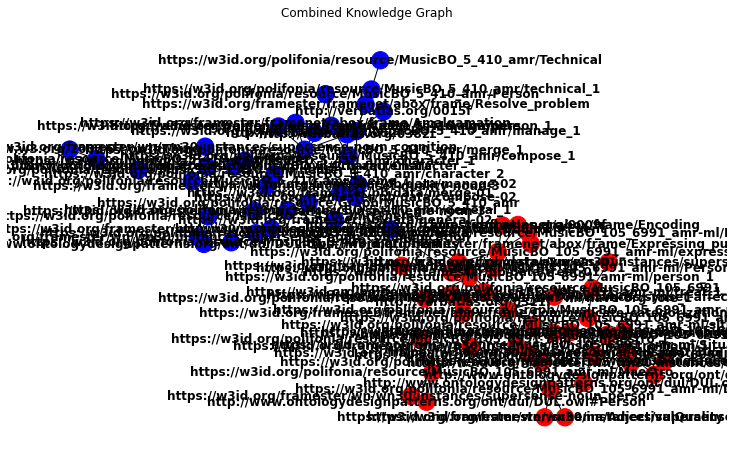

In [15]:
#4.1 Use a simple similarity calculation method based on (the number of nodes and edges)

import networkx as nx
import matplotlib.pyplot as plt
from rdflib import Graph

# Create and parse the first graph
graph1 = nx.Graph()
rdf_graph1 = Graph()
rdf_graph1.parse("x/0_1_EN.nq", format="nquads")
for triple in rdf_graph1:
    subject, predicate, obj = triple
    graph1.add_node(subject)
    graph1.add_node(obj)
    graph1.add_edge(subject, obj)

# Create and parse the second graph
graph2 = nx.Graph()
rdf_graph2 = Graph()
rdf_graph2.parse("x/0_1_ITA.nq", format="nquads")
for triple in rdf_graph2:
    subject, predicate, obj = triple
    graph2.add_node(subject)
    graph2.add_node(obj)
    graph2.add_edge(subject, obj)

# Define the compare function
def compare_knowledge_graphs(graph1, graph2):
    num_nodes1 = len(graph1.nodes)
    num_nodes2 = len(graph2.nodes)
    num_edges1 = len(graph1.edges)
    num_edges2 = len(graph2.edges)
    
    node_similarity = min(num_nodes1 / num_nodes2, num_nodes2 / num_nodes1)
    edge_similarity = min(num_edges1 / num_edges2, num_edges2 / num_edges1)
    
    overall_similarity = (node_similarity + edge_similarity) / 2

    return overall_similarity

# Compare knowledge graphs and calculate similarity score
similarity_score = compare_knowledge_graphs(graph1, graph2)
print(f"Similarity Score: {similarity_score}")

# Create a combined graph for visualization
combined_graph = nx.compose(graph1, graph2)

# Assign different colors to nodes of each original graph
node_colors = []
for node in combined_graph.nodes:
    if node in graph1.nodes:
        node_colors.append('blue')  # Blue color for nodes from the first graph
    else:
        node_colors.append('red')   # Red color for nodes from the second graph

# Visualize the combined graph
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(combined_graph, seed=42)  # You can choose a different layout if desired
nx.draw(combined_graph, pos, with_labels=True, node_color=node_colors, font_weight='bold', node_size=300)
plt.title("Combined Knowledge Graph")

plt.show()


In [16]:
#4.2 Improved similarity measure method, taking into account the similarity of nodes, edges and predicates

import networkx as nx
from rdflib import Graph
from collections import defaultdict

def parse_rdf_graph(file_path):
    rdf_graph = Graph()
    rdf_graph.parse(file_path, format="nquads")
    return rdf_graph

def compare_knowledge_graphs(graph1, graph2):
    # Get nodes, edges, and predicates of the two knowledge graphs
    nodes1 = set(graph1.nodes)
    nodes2 = set(graph2.nodes)
    edges1 = set(graph1.edges)
    edges2 = set(graph2.edges)
    
    predicates1 = set([data.get('label') for _, _, data in graph1.edges(data=True)])
    predicates2 = set([data.get('label') for _, _, data in graph2.edges(data=True)])
    
    # Calculate node similarity
    node_intersection = len(nodes1.intersection(nodes2))
    node_union = len(nodes1.union(nodes2))
    node_similarity = node_intersection / node_union if node_union > 0 else 0.0
    
    # Calculate edge similarity
    edge_intersection = len(edges1.intersection(edges2))
    edge_union = len(edges1.union(edges2))
    edge_similarity = edge_intersection / edge_union if edge_union > 0 else 0.0
    
    # Calculate predicate similarity
    predicate_intersection = len(predicates1.intersection(predicates2))
    predicate_union = len(predicates1.union(predicates2))
    predicate_similarity = predicate_intersection / predicate_union if predicate_union > 0 else 0.0
    
    # Return an overall similarity score
    overall_similarity = (node_similarity + edge_similarity + predicate_similarity) / 3
    
    return overall_similarity

def main():
    try:
        # Create and parse the first graph
        rdf_graph1 = parse_rdf_graph("x/0_1_EN.nq")
        graph1 = nx.Graph()
        for triple in rdf_graph1:
            subject, predicate, obj = triple
            graph1.add_node(subject)
            graph1.add_node(obj)
            graph1.add_edge(subject, obj, label=predicate)

        # Create and parse the second graph
        rdf_graph2 = parse_rdf_graph("x/0_1_ITA.nq")
        graph2 = nx.Graph()
        for triple in rdf_graph2:
            subject, predicate, obj = triple
            graph2.add_node(subject)
            graph2.add_node(obj)
            graph2.add_edge(subject, obj, label=predicate)

        # Compare knowledge graphs and output the similarity score
        similarity_score = compare_knowledge_graphs(graph1, graph2)
        print(f"Similarity Score: {similarity_score:.2f}")

    except FileNotFoundError:
        print("File not found. Please check the file paths.")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()


Similarity Score: 0.10


In [4]:
#4.3 Used the Word2Vec model to obtain the embedded representation of node labels
#4.3.2 Node embedding representation: Using the Word2Vec model to obtain the embedding representation of node labels is a good method, which takes into account the semantic information of node labels.
#4.3.3 Word segmentation processing: Use NLTK’s word segmenter to segment the text.
#4.3.4 Word2Vec parameters: Parameters of Word2Vec model, such as vector_size, window and min_count
#4.3.5 Exception handling
import networkx as nx
from rdflib import Graph
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
import numpy as np

def parse_rdf_graph(file_path):
    rdf_graph = Graph()
    rdf_graph.parse(file_path, format="nquads")
    return rdf_graph

def tokenize_text(text):
    # Tokenize the text using NLTK
    return word_tokenize(text)

def train_word2vec_model(node_labels, vector_size=100, window=5, min_count=1):
    # Train a Word2Vec model using node label texts
    tokenized_labels = [tokenize_text(label) for label in node_labels]
    model = Word2Vec(sentences=tokenized_labels, vector_size=vector_size, window=window, min_count=min_count)
    return model

def get_word2vec_embeddings(node_labels, word2vec_model):
    # Get Word2Vec embeddings for node labels
    embeddings = []
    for label in node_labels:
        tokens = tokenize_text(label)
        label_embedding = np.mean([word2vec_model.wv[token] for token in tokens if token in word2vec_model.wv], axis=0)
        embeddings.append(label_embedding)
    return embeddings

def compare_knowledge_graphs(graph1, graph2, word2vec_model):
    # Extract node label texts
    node_labels1 = [str(node) for node in graph1.nodes]
    node_labels2 = [str(node) for node in graph2.nodes]

    # Train Word2Vec model and obtain node embeddings
    word2vec_model = train_word2vec_model(node_labels1 + node_labels2)
    embeddings1 = get_word2vec_embeddings(node_labels1, word2vec_model)
    embeddings2 = get_word2vec_embeddings(node_labels2, word2vec_model)

    # Calculate cosine similarity of node embeddings
    similarity_matrix = cosine_similarity(embeddings1, embeddings2)

    # Calculate average node similarity
    avg_node_similarity = np.mean(similarity_matrix)

    return avg_node_similarity

def main():
    try:
        # Create and parse the first graph
        rdf_graph1 = parse_rdf_graph("x/0_1_EN.nq")
        graph1 = nx.Graph()
        for triple in rdf_graph1:
            subject, predicate, obj = triple
            if subject and predicate and obj:
                graph1.add_node(subject)
                graph1.add_node(obj)
                graph1.add_edge(subject, obj, label=predicate)

        # Create and parse the second graph
        rdf_graph2 = parse_rdf_graph("x/0_1_ITA.nq")
        graph2 = nx.Graph()
        for triple in rdf_graph2:
            subject, predicate, obj = triple
            if subject and predicate and obj:
                graph2.add_node(subject)
                graph2.add_node(obj)
                graph2.add_edge(subject, obj, label=predicate)

        # Compare knowledge graphs and output the similarity score
        word2vec_model = train_word2vec_model(list(graph1.nodes) + list(graph2.nodes))
        similarity_score = compare_knowledge_graphs(graph1, graph2, word2vec_model)
        print(f"Similarity Score: {similarity_score:.2f}")

    except FileNotFoundError:
        print("File not found. Please check the file paths.")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()


Similarity Score: 0.56


In [11]:
#5natural language explanation
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch

# Load the pre-trained GPT-2 model and its word segmenter
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

def generate_explanation(kg_diffs):
    # Input text to build the model, where `kg_diffs` is a string containing a description of the differences in the knowledge graph
    prompt = f"The differences in the knowledge graphs reflect: {kg_diffs}. This implies that"

    # Encode input text using a tokenizer
    inputs = tokenizer.encode(prompt, return_tensors="pt")

    outputs = model.generate(inputs, max_length=535, num_return_sequences=1, temperature=0.7, no_repeat_ngram_size=2, pad_token_id=tokenizer.eos_token_id)

    # Decode the resulting text into a string
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return generated_text


kg_diffs = "After comparative analysis of the two knowledge graphs, we found that their similarity score at the semantic level of node labels is 0.56. This score shows that, although there is a certain degree of similarity, the two graphs also exhibit clear differences in expressing certain concepts and entities in the music domain. In particular, this may reflect different authors' unique perspectives and interpretations of musical history, styles, or events. We wanted to dig deeper into the meaning behind this similarity score: how does it reflect the commonalities and divergences between the two knowledge graphs in describing musical elements? What cultural or historical contextual differences might these similarities and differences reveal? Please provide a natural language explanation based on this similarity score to help us better understand the connections and differences between the two knowledge graphs."
explanation = generate_explanation(kg_diffs)
print(explanation)


The differences in the knowledge graphs reflect: After comparative analysis of the two knowledge graphs, we found that their similarity score at the semantic level of node labels is 0.56. This score shows that, although there is a certain degree of similarity, the two graphs also exhibit clear differences in expressing certain concepts and entities in the music domain. In particular, this may reflect different authors' unique perspectives and interpretations of musical history, styles, or events. We wanted to dig deeper into the meaning behind this similarity score: how does it reflect the commonalities and divergences between the two knowledge graphs in describing musical elements? What cultural or historical contextual differences might these similarities and differences reveal? Please provide a natural language explanation based on this similarity score to help us better understand the connections and differences between the two knowledge graphs.. This implies that the similarity sc